In [2]:
import sys
print(sys.path)

import scipy
scipy.__version__

import os
os.environ["XLA_FLAGS"]="--xla_cpu_enable_fast_math=false"

['/astro/users/ncaplar/epyc_notebooks', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python310.zip', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/lib-dynload', '', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/astro/users/ncaplar/github/tinygp_carma/tinygp/src']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)


import tinygp
from tinygp import kernels, GaussianProcess
from tinygp.kernels import quasisep
print(tinygp.__version__)



import lsstseries as ls
from lsstseries import Ensemble
from lsstseries.analysis.structurefunction2 import calc_sf2
from lsstseries.analysis.stetsonj import calc_stetson_J

# print out all outputs from the cell, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


0.2.3.dev57+g60dde94


In [4]:
# Define a context manager to suppress stdout and stderr.
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in 
    Python, i.e. will suppress all print, even if the print originates in a 
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).      

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds =  [os.open(os.devnull,os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0],1)
        os.dup2(self.null_fds[1],2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0],1)
        os.dup2(self.save_fds[1],2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

# Ensamble effort

In [7]:
# import example ZTF data
# takes between 10 to 40 seconds to load
# takes between 1min 25sec & 1min 45sec
ens = Ensemble()
ens = ens.from_parquet('/data3/epyc/data3/hipscat/catalogs/ztf_dr14_explode/Norder1/Npix33/source.parquet',
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

# keep only lightcurves with more than 100 observations 
# I dont know what dropna exactly is
ens.dropna(1).prune(100)
ens._data = ens._data.repartition(partition_size='1000KB')

# computed in order to see the data
# between 1min 33sec and 5min 30sec
ens_comp = ens._data.compute()

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34040 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38052
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:34040
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34120'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36613'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43257'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44176'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44968'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34486'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45493'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42955'
INFO:

In [7]:
ens_comp.shape

(50154450, 10)

In [52]:
theta_init = {
     "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log(1.2),
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(5.0),
    "log_sigma": np.log(4.3)
}

def create_alt_theta_init(theta_init, rs = 42):
    np.random.seed(rs)
    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.random.normal(np.exp(theta_init['log_beta']),
                                        np.exp(theta_init['log_beta']))}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t, y, yerr):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    # using np.median instead of np.mean does nto work
    return GaussianProcess(kernel, t, diag=yerr, mean=np.mean(y))

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y, yerr):
    gp = build_gp(theta, t, y, yerr)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

# print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
# print(
#     f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
# )

# 4. optimize
#with suppress_stdout_stderr():
#    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
#    soln = solver.run(theta_init, t=t, y=y)
# print(f"Final negative log likelihood: {soln.state.fun_val}")

In [53]:
create_alt_theta_init(theta_init)

{'log_per_amp': 8.980284918067396,
 'log_scale': 4.308678494144076,
 'log_sigma': 7.085060713832977,
 'log_alpha': array([2.52302986, 0.91901595]),
 'log_beta': 0.9190356516609833}

In [10]:
%%time
# This will run on first len_req objects, with n_init initial solutions

# Find all unique indices - this is used to select objects
uniq_id = np.unique(ens_comp.index)


# how many objects are we going to analyze
len_req = 20
#len_req = len(uniq_id)

# how many initial position for each lc
n_init = 100

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood, jit=True, tol = 1)
# prepare an array where teh results will be stored
res_man = []
for i, v in tqdm(enumerate(uniq_id[0:len_req])):

    ens_comp_single = ens_comp.loc[v]
    # select r band
    bool_r = ens_comp_single['band']=='r'
    mjd = ens_comp_single['mjd'][bool_r]
    # print(len(mjd))
    len_cut = np.floor_divide(len(mjd),10)*10
    mjd = mjd[:len_cut].values
    mag = ens_comp_single['mag'][bool_r].values[:len_cut]
    magerr = ens_comp_single['maggerr'][bool_r].values[:len_cut]

    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    #print(len(mjd))
    # 3. evaluate in situ
    #obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

    #with suppress_stdout_stderr():

    #soln = solver.run(theta_init, t=mjd, y=mag, yerr=magerr)

    list_fun_val = []
    for j in range(n_init):
        alt_theta_init = create_alt_theta_init(theta_init)
        soln = solver.run(alt_theta_init, t=mjd, y=mag, yerr=magerr)
        list_fun_val.append([soln.state.fun_val.item(),
                            np.array(soln.params['log_alpha'])[0],
                            np.array(soln.params['log_alpha'])[1],
                            float(soln.params['log_beta']),
                            float(soln.params['log_per_amp']),
                            float(soln.params['log_scale']),
                            float(soln.params['log_sigma'])])
        
    array_fun_val = np.array(list_fun_val)

    res_man.append(array_fun_val)

0it [00:00, ?it/s]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
20it [00:40,  2.01s/it]

CPU times: user 42.2 s, sys: 6.9 s, total: 49.1 s
Wall time: 41.9 s


In [ ]:
# to dask
# do results make sense?

In [ ]:
i = 8
res_sin = res_man[i]

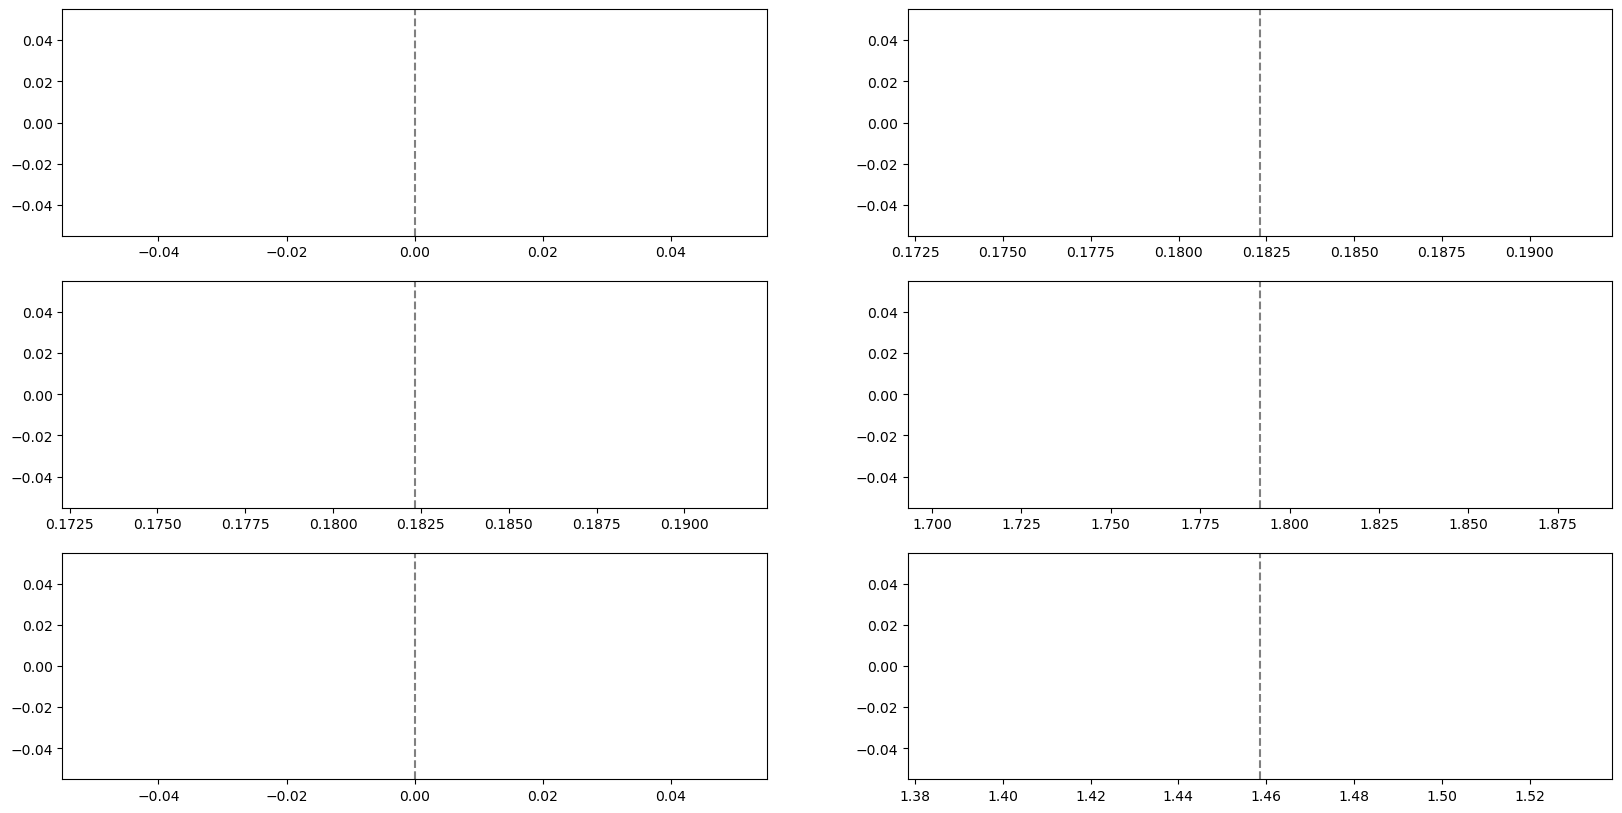

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(3,2,1);
plt.scatter(res_sin[:,1], np.log10(res_sin[:,0]))
plt.axvline(np.log(1), c='gray', ls = '--')

plt.subplot(3,2,2)
plt.scatter(res_sin[:,2], np.log10(res_sin[:,0]))
plt.axvline(np.log(1.2), c='gray', ls = '--')

plt.subplot(3,2,3)
plt.scatter(res_sin[:,3], np.log10(res_sin[:,0]))
plt.axvline(np.log(1.2), c='gray', ls = '--')

plt.subplot(3,2,4)
plt.scatter(res_sin[:,4], np.log10(res_sin[:,0]))
plt.axvline(np.log(6), c='gray', ls = '--')

plt.subplot(3,2,5)
plt.scatter(res_sin[:,5], np.log10(res_sin[:,0]))
plt.axvline(np.log(1), c='gray', ls = '--')

plt.subplot(3,2,6)
plt.scatter(res_sin[:,6], np.log10(res_sin[:,0]))
plt.axvline(np.log(4.3), c='gray', ls = '--');

In [ ]:
v = uniq_id[0:len_req][i]
ens_comp_single = ens_comp.loc[v]
# select r band
bool_r = ens_comp_single['band']=='r'
mjd = ens_comp_single['mjd'][bool_r]
len_cut = np.floor_divide(len(mjd),10)*10
mjd = mjd[:len_cut].values
mag = ens_comp_single['mag'][bool_r].values[:len_cut]
magerr = ens_comp_single['maggerr'][bool_r].values[:len_cut]

sort_arr = np.argsort(mjd)
mjd = mjd[sort_arr]
mag = mag[sort_arr]
magerr = magerr[sort_arr]

In [ ]:
best_sol = res_man[i][res_man[i][:,0]==np.min(res_man[i][:,0])][0]
best_sol

array([       inf, 2.52302986, 0.91901595, 0.91903565, 8.98028492,
       4.30867849, 7.08506071])

In [ ]:
soln.params['log_alpha'] = jnp.array([best_sol[1], best_sol[2]])
soln.params['log_beta'] = jnp.array(best_sol[3])
soln.params['log_per_amp'] = jnp.array(best_sol[4])
soln.params['log_scale'] = jnp.array(best_sol[5])
soln.params['log_sigma'] = jnp.array(best_sol[6])

In [ ]:
soln.params

{'log_alpha': DeviceArray([2.52302986, 0.91901595], dtype=float64),
 'log_beta': DeviceArray(0.91903565, dtype=float64),
 'log_per_amp': DeviceArray(8.98028492, dtype=float64),
 'log_scale': DeviceArray(4.30867849, dtype=float64),
 'log_sigma': DeviceArray(7.08506071, dtype=float64)}

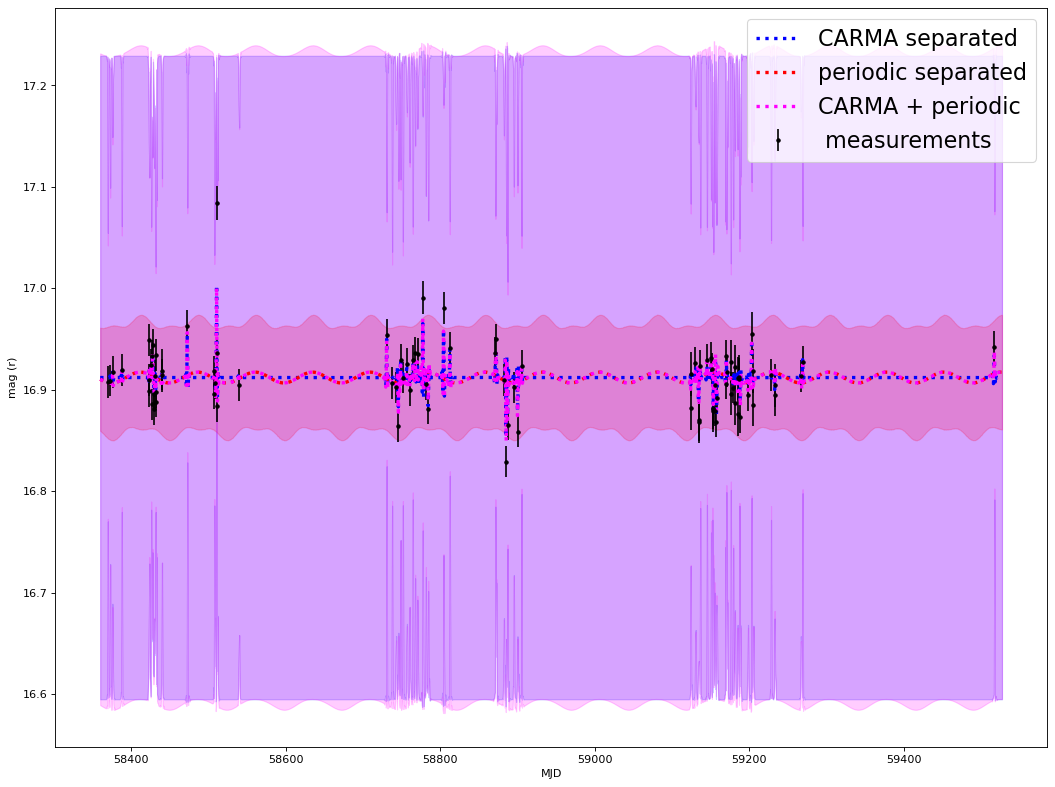

In [ ]:
# define grid over which to evaluate
x = np.linspace(np.min(mjd)-10, np.max(mjd)+10, 2000)

with suppress_stdout_stderr():
    gp = build_gp(soln.params, mjd, mag, magerr)
    cond_gp = gp.condition(mag, x).gp
    mu, var = cond_gp.loc, cond_gp.variance

    mu_carma = gp.condition(mag, x, kernel=gp.kernel.kernel1).gp.loc
    var_carma = gp.condition(mag, x, kernel=gp.kernel.kernel1).gp.variance

    mu_periodic = gp.condition(mag, x, kernel=gp.kernel.kernel2).gp.loc
    var_periodic = gp.condition(mag, x, kernel=gp.kernel.kernel2).gp.variance


plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(true_t, true_y, "k", lw=3.5, alpha=0.3, label = ' truth')
plt.errorbar(mjd, mag, yerr=magerr, fmt=".k", capsize=0, label = ' measurements')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("MJD")
plt.ylabel("mag (r)")
plt.legend(fontsize = 20);

In [176]:
len(mag)

90

# Checking the algorithm on a known test case 

In [5]:
import eztao
import numpy as np
import matplotlib.pyplot as plt
print(eztao.__version__)

from eztao.carma import DRW_term
from eztao.ts import gpSimRand
from eztao.carma import gp_psd

0.4.0


In [6]:
jax.devices()
jax.__version__
from jax.config import config
# config.update("jax_debug_nans", True) 
config.update("jax_enable_x64", True)
#jax.jaxlib.__version__

[CpuDevice(id=0)]

'0.3.25'

In [7]:
import numpy as np
from scipy import stats
x = stats.norm.rvs(size=100, scale=1, random_state=123456)
x.std()
stats.median_abs_deviation(x)

0.9973906394005013

0.82832610097857

alpha_1, beta_0: 0.009999999999999995,0.02828427124746189


<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

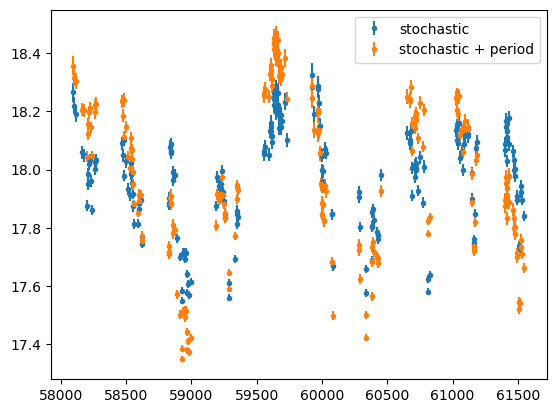

In [8]:
# simulate stohastic component
amp = 0.2
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
mjd = t + 58000

alpha_1, beta_0 = DRW_kernel.get_carma_parameter()
print('alpha_1, beta_0: ' + str(alpha_1) +','+ str(beta_0))

# simulate periodic component
y_per = np.sin(t/200)*0.2

mag = y + 18 
# periodic component added
mag_per = y + 18 + y_per

magerr = yerr
plt.errorbar(mjd, mag, magerr, fmt='.', label = 'stochastic')
plt.errorbar(mjd, mag_per, magerr, fmt='.', label = 'stochastic + period')
plt.legend()

In [16]:
# GP process that simulates DRW

alpha =alpha_1    
beta = beta_0
# "log_alpha": np.log([1.0, 1.2])
theta_drw_init = {   
     "log_alpha": np.log(alpha)*0.9,
    "log_beta": np.log(beta)*0.9
}

x = np.linspace(np.min(mjd)-10, np.max(mjd)+10, 2000)

def create_alt_theta_drw_init(theta_init, rs = 42):
    np.random.seed(rs)
    alt_theta_init = {
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.random.normal(np.exp(theta_init['log_beta']),
                                        np.exp(theta_init['log_beta']))}
    return alt_theta_init

# 1. combination of carma and periodic
def build_drw_gp(theta, t, y, yerr):
   
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
        
    # using np.median instead of np.mean does not work
    return GaussianProcess(carma_kernel, t, diag=yerr, mean=np.mean(y))

# 2. create loss function
@jax.jit
def neg_log_likelihood_drw(theta, t, y, yerr):
    gp_drw = build_drw_gp(theta, t, y, yerr)
    return -gp_drw.log_probability(y)

# 3. evaluate in situ
obj_drw = jax.jit(jax.value_and_grad(neg_log_likelihood_drw))

obj_drw_no_jit = jax.grad(neg_log_likelihood_drw)

solver_drw = jaxopt.ScipyMinimize(fun=neg_log_likelihood_drw)

print(f"Initial negative log likelihood: {obj_drw(theta_drw_init, t, y, yerr)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_drw(theta_drw_init, t, y, yerr)[1]}"
)
#print(
#   f"Gradient of the negative log likelihood, wrt the parameters:\n{obj_drw_no_jit(theta_drw_init, t, y, yerr)}"
#)
# 4. optimize
#with suppress_stdout_stderr():
#    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
#    soln = solver.run(theta_init, t=t, y=y)
# print(f"Final negative log likelihood: {soln.state.fun_val}")

alpha: 0.015848931924611127
beta: 0.04040084923234528
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.22692142]
Initial negative log likelihood: -117.32312918115404
alpha: 0.015848931924611127
beta: 0.04040084923234528
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.22692142]
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(nan, dtype=float64), 'log_beta': DeviceArray(nan, dtype=float64)}


In [ ]:
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta_drw_init["log_alpha"]), beta=jnp.exp(theta_drw_init["log_beta"])
    )

In [ ]:
carma_kernel

CARMA(alpha=DeviceArray([0.001], dtype=float64), beta=DeviceArray([0.02828], dtype=float64), sigma=DeviceArray(1., dtype=float64), arroots=DeviceArray([-0.001+0.j], dtype=complex128), acf=DeviceArray([0.3998792+0.j], dtype=complex128), real_mask=DeviceArray([1.], dtype=float64), complex_mask=DeviceArray([0.], dtype=float64), complex_select=DeviceArray([0.], dtype=float64), obsmodel=DeviceArray([0.63236002], dtype=float64), _eta=1e-30)

In [11]:
import tinygp
tinygp.C

In [24]:
alpha = 0.01
beta = 0.02828
eta = 1e-30

sigma = jnp.ones(())
alpha = jnp.atleast_1d(alpha)
beta = jnp.atleast_1d(beta)
assert alpha.ndim == 1
assert beta.ndim == 1
p = alpha.shape[0]
assert beta.shape[0] <= p

## find acvf => Eqn. 4 in Kelly+14
arroots = quasisep.CARMA.roots(jnp.append(alpha, 1.0))
acf = quasisep.CARMA.carma_acvf(arroots, alpha, beta * sigma)

## mask and index for real/complex components in the obs model matrix
real_mask = jnp.where(arroots.imag == 0.0, jnp.ones(p), jnp.zeros(p))
complex_mask = -real_mask + 1
complex_idx = jnp.cumsum(-real_mask + 1) * complex_mask
complex_select = complex_mask * complex_idx % 2

## construct obs model => real + complex
om_real = jnp.sqrt(jnp.abs(acf.real))

a, b, c, d = (
    2 * acf.real * complex_mask,
    2 * acf.imag * complex_mask,
    -arroots.real * complex_mask,
    -arroots.imag * complex_mask,
)
c2 = jnp.square(c)
d2 = jnp.square(d)
s2 = c2 + d2
h2_2 = d2 * (a * c - b * d) / (2 * c * s2 + eta * real_mask)
h2 = jnp.sqrt(h2_2)
h1 = (c * h2 - jnp.sqrt(a * d2 - s2 * h2_2)) / (d + eta * real_mask)
om_complex = jnp.array([h1, h2])

obsmodel = (om_real * real_mask) + jnp.ravel(om_complex)[
    ::2
] * complex_mask


(om_real * real_mask)

DeviceArray([0.1999698], dtype=float64)

In [20]:
%debug

> /astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/jax/_src/dispatch.py(849)_check_special()
    847   if dtypes.issubdtype(dtype, np.inexact):
    848     if config.jax_debug_nans and np.any(np.isnan(np.asarray(buf))):
--> 849       raise FloatingPointError(f"invalid value (nan) encountered in {name}")
    850     if config.jax_debug_infs and np.any(np.isinf(np.asarray(buf))):
    851       raise FloatingPointError(f"invalid value (inf) encountered in {name}")



In [17]:
type(build_drw_gp(theta_drw_init, t, y, yerr).solver)

tinygp.solvers.quasisep.solver.QuasisepSolver

In [13]:
obj_drw_no_jit(theta_drw_init, t, y, yerr)

{'log_alpha': DeviceArray(nan, dtype=float64),
 'log_beta': DeviceArray(nan, dtype=float64)}

In [56]:
list_fun_val_test = []
list_of_theta_init = []
for j in range(200):
    alt_theta_init = create_alt_theta_init(theta_init, rs = j)
    list_of_theta_init.append(alt_theta_init)
    soln = solver.run(alt_theta_init, t=mjd, y=mag, yerr=magerr)
    list_fun_val_test.append([soln.state.fun_val.item(),
                        np.array(soln.params['log_alpha'])[0],
                        np.array(soln.params['log_alpha'])[1],
                        float(soln.params['log_beta']),
                        float(soln.params['log_per_amp']),
                        float(soln.params['log_scale']),
                        float(soln.params['log_sigma'])])
 
array_theta_init = np.array(list_of_theta_init) 
array_fun_val_test = np.array(list_fun_val_test)


In [15]:
list_fun_val_test_drw = []
list_of_theta_init_drw = []
for j in range(200):
    alt_theta_init_drw = create_alt_theta_drw_init(theta_drw_init, rs = j)
    list_of_theta_init_drw.append(list(alt_theta_init_drw.values()))
    soln_drw = solver_drw.run(alt_theta_init_drw, t=mjd, y=mag, yerr=magerr)
    list_fun_val_test_drw.append([soln_drw.state.fun_val.item(),
                        float(soln_drw.params['log_alpha']),
                        float(soln_drw.params['log_beta'])])
 
array_theta_init_drw = np.array(list_of_theta_init_drw) 
array_fun_val_test_drw = np.array(list_fun_val_test_drw)

alpha: 1.021671822127856
beta: 1.0285309579574635
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.71952628]
alpha: 1.0205652509163783
beta: 1.007830974154386
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.70542739]
alpha: 1.0045343685096697
beta: 1.0191421029371772
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.719014]
alpha: 1.0218666052848622
beta: 1.0292824571340806
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.71998338]
alpha: 1.0081823386291853
beta: 1.0305952652699246
c: [0.]
h2: [0.]
a: [0.]
d2: [0.]
s2: [0.]
h2_2: [0.]
d: [-0.]
eta: 1e-30
real_mask: [1.]
h1_f: [0.]
h1_b: [1.e-30]
h1: [0.]
obsmodel: [0.72577767]
alpha: 1.

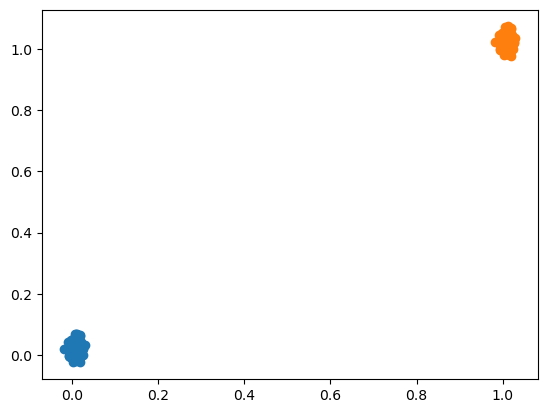

In [16]:
plt.scatter(array_theta_init_drw[:,0],array_theta_init_drw[:,1])
plt.scatter(np.exp(array_fun_val_test_drw[:,1]),np.exp(array_fun_val_test_drw[:,2]))

In [17]:
array_fun_val_test_drw

array([[ 1.22256596e+02,  2.14403268e-02,  2.81315298e-02],
       [ 1.18688315e+02,  2.03566414e-02,  7.80047122e-03],
       [ 1.21996132e+02,  4.52411923e-03,  1.89611978e-02],
       [ 1.22372557e+02,  2.16309601e-02,  2.88619159e-02],
       [ 1.23713674e+02,  8.14904479e-03,  3.01365628e-02],
       [ 1.20455691e+02,  1.11793789e-02,  1.34439520e-02],
       [ 1.24776995e+02,  5.33838767e-03,  3.47386172e-02],
       [ 1.19172290e+02,  2.08699920e-02,  1.07302228e-02],
       [ 1.25835496e+02,  8.46430633e-03,  4.20174121e-02],
       [ 1.20885533e+02,  7.76544433e-03,  1.42742629e-02],
       [ 1.23675357e+02,  1.80857561e-02,  3.44628598e-02],
       [ 1.19784098e+02,  2.13270955e-02,  1.43440027e-02],
       [ 1.19169340e+02,  1.14257234e-02,  6.40069365e-03],
       [ 1.25123418e+02,  2.23094118e-03,  3.52361369e-02],
       [ 1.21230637e+02,  1.97903432e-02,  2.16826751e-02],
       [ 1.23362870e+02,  5.33416168e-03,  2.69084981e-02],
       [ 1.16336453e+02,  8.74932389e-03

In [93]:
best_sol_test = array_fun_val_test[array_fun_val_test[:,0]==np.min(array_fun_val_test[:,0])][0] 

soln.params['log_alpha'] = jnp.array([best_sol_test[1], best_sol_test[2]])
soln.params['log_beta'] = jnp.array(best_sol_test[3])
soln.params['log_per_amp'] = jnp.array(best_sol_test[4])
soln.params['log_scale'] = jnp.array(best_sol_test[5])
soln.params['log_sigma'] = jnp.array(best_sol_test[6])
print(best_sol_test[0])
soln.params

-105.88018308943214


{'log_alpha': DeviceArray([-0.66338939,  3.26314523], dtype=float64),
 'log_beta': DeviceArray(-0.50048996, dtype=float64),
 'log_per_amp': DeviceArray(8.90808084, dtype=float64),
 'log_scale': DeviceArray(0.88919417, dtype=float64),
 'log_sigma': DeviceArray(2.85201028, dtype=float64)}

In [97]:
best_sol_test_drw = array_fun_val_test_drw[array_fun_val_test_drw[:,0]==np.min(array_fun_val_test_drw[:,0])][0] 

soln_drw.params['log_alpha'] = jnp.array(best_sol_test_drw[1])
soln_drw.params['log_beta'] = jnp.array(best_sol_test_drw[2])
print(best_sol_test_drw[0])
soln_drw.params

# soln_drw.params['log_alpha'] = jnp.array(np.log(0.01))
# soln_drw.params['log_beta'] = jnp.array(np.log(0.02828))

110.15458928049212


{'log_alpha': DeviceArray(0.02367858, dtype=float64),
 'log_beta': DeviceArray(-0.03370045, dtype=float64)}

In [98]:
array_fun_val_test_drw

array([[ 1.23072930e+02,  2.76405235e-02,  3.95964459e-02],
       [ 1.17995336e+02,  2.62434536e-02,  1.09795286e-02],
       [ 1.22535883e+02,  5.83242153e-03,  2.66887741e-02],
       [ 1.23239572e+02,  2.78862847e-02,  4.06244986e-02],
       [ 1.25012148e+02,  1.05056171e-02,  4.24186237e-02],
       [ 1.20413919e+02,  1.44122749e-02,  1.89229921e-02],
       [ 1.26495731e+02,  6.88216327e-03,  4.88962310e-02],
       [ 1.18687261e+02,  2.69052570e-02,  1.51032912e-02],
       [ 1.28031850e+02,  1.09120472e-02,  5.91414757e-02],
       [ 1.20990601e+02,  1.00110855e-02,  2.00916937e-02],
       [ 1.25056018e+02,  2.33158650e-02,  4.85080894e-02],
       [ 1.19560232e+02,  2.74945474e-02,  2.01898557e-02],
       [ 1.18590307e+02,  1.47298583e-02,  9.00927613e-03],
       [ 1.26957368e+02,  2.87609338e-03,  4.95965132e-02],
       [ 1.21599225e+02,  2.55133911e-02,  3.05193808e-02],
       [ 1.24485709e+02,  6.87671518e-03,  3.78749715e-02],
       [ 1.14545539e+02,  1.12794872e-02

In [99]:
"""
soln.params['log_alpha'] = jnp.array([0.75693312, 0.7612437])
soln.params['log_beta'] = jnp.array(1.33327584)
soln.params['log_per_amp'] = jnp.array(1.50052707)
soln.params['log_scale'] = jnp.array(-0.32671506)
soln.params['log_sigma'] = jnp.array(0.87615023)
print(best_sol_test[0])
soln.params
"""

"\nsoln.params['log_alpha'] = jnp.array([0.75693312, 0.7612437])\nsoln.params['log_beta'] = jnp.array(1.33327584)\nsoln.params['log_per_amp'] = jnp.array(1.50052707)\nsoln.params['log_scale'] = jnp.array(-0.32671506)\nsoln.params['log_sigma'] = jnp.array(0.87615023)\nprint(best_sol_test[0])\nsoln.params\n"

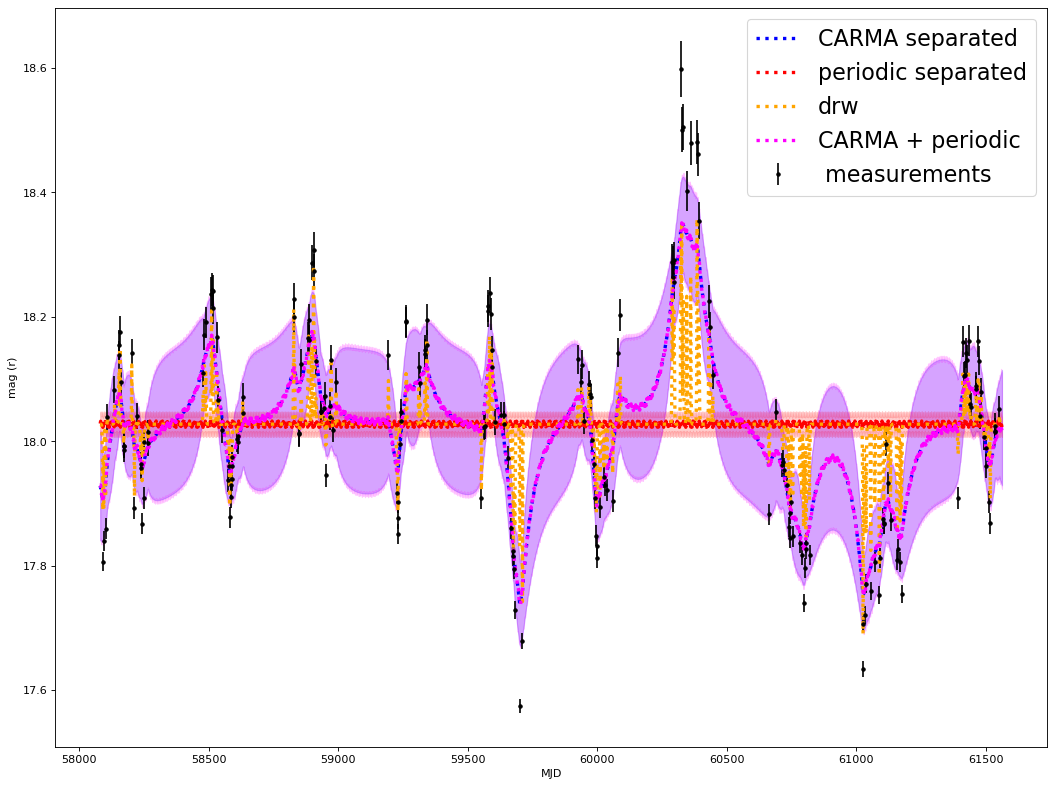

In [100]:
# define grid over which to evaluate
x = np.linspace(np.min(mjd)-10, np.max(mjd)+10, 2000)

with suppress_stdout_stderr():
    gp = build_gp(soln.params, mjd, mag, magerr)
    cond_gp = gp.condition(mag, x).gp
    mu, var = cond_gp.loc, cond_gp.variance

    mu_carma = gp.condition(mag, x, kernel=gp.kernel.kernel1).gp.loc
    var_carma = gp.condition(mag, x, kernel=gp.kernel.kernel1).gp.variance

    mu_periodic = gp.condition(mag, x, kernel=gp.kernel.kernel2).gp.loc
    var_periodic = gp.condition(mag, x, kernel=gp.kernel.kernel2).gp.variance
    
    gp_drw = build_drw_gp(soln_drw.params, mjd, mag, magerr)
    cond_gp_drw = gp_drw.condition(mag, x).gp
    mu_drw, var_drw = cond_gp_drw.loc, cond_gp_drw.variance


plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
#plt.scatter(mjd, 18 + y_per label = ' truth')
#plt.plot(x,np.sin(x/200)*0.2+18)

plt.errorbar(mjd, mag, yerr=magerr, fmt=".k", capsize=0, label = ' measurements')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.plot(x, mu_drw, color="orange", ls=':', lw=3, label = 'drw')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("MJD")
plt.ylabel("mag (r)")
plt.legend(fontsize = 20);

/tmp/ipykernel_43177/2977407855.py:4: RuntimeWarning: underflow encountered in exp
  plt.plot(np.log10(freq), np.log10(amp**2 * np.exp(-freq/tau)), label="real stochastic kernel")
/tmp/ipykernel_43177/2977407855.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(amp**2 * np.exp(-freq/tau)), label="real stochastic kernel")


/tmp/ipykernel_43177/2977407855.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")


/tmp/ipykernel_43177/2977407855.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(gp_drw.kernel(freq[:1], freq)[0]), label="drw kernel")


(-3.0, -1.0)

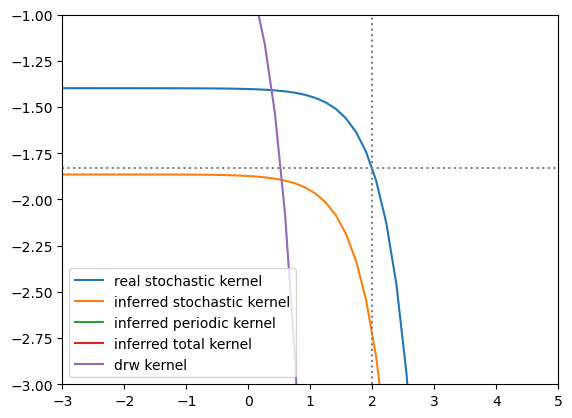

In [101]:
freq = np.logspace(-3, 5)
true_psd = gp_psd(DRW_kernel)

plt.plot(np.log10(freq), np.log10(amp**2 * np.exp(-freq/tau)), label="real stochastic kernel")
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel2(freq[:1], freq)[0]), label="inferred periodic kernel")
plt.plot(np.log10(freq), np.log10(gp.kernel(freq[:1], freq)[0]), label="inferred total kernel")

plt.plot(np.log10(freq), np.log10(gp_drw.kernel(freq[:1], freq)[0]), label="drw kernel")

_ = plt.xlim(np.log10(freq.min()), np.log10(freq.max()))
plt.ylim(-3, -1)
plt.legend()
plt.axvline(np.log10(tau), color='gray', ls=':')
plt.axhline(np.log10(amp**2/np.exp(1)), color='gray', ls=':')

/tmp/ipykernel_43177/2525896384.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]),
/tmp/ipykernel_43177/2525896384.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]),
/tmp/ipykernel_43177/2525896384.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")


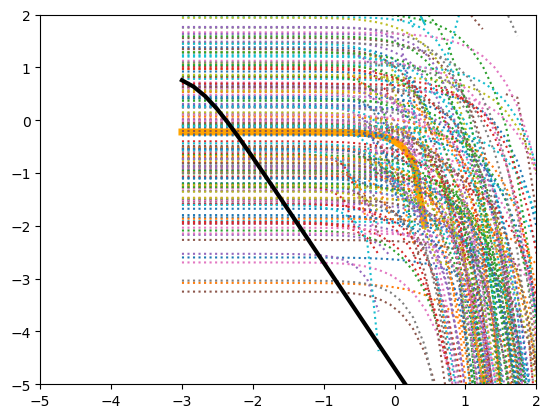

In [102]:
for j in range(0,200):
    if j == 0:
        single_theta_init = theta_init
    else:
        single_theta_init = array_theta_init[j]
    soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                        single_theta_init['log_alpha'][1]])
    soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
    soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
    soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
    soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
    gp = build_gp(soln.params, mjd, mag, magerr)
    if j == 0: 
        plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
                 color='orange', lw=5, label="inferred stochastic kernel")
    else:
        plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]),
                 ls =':', label="inferred stochastic kernel")
    
    
plt.xlim(-5, 2)
plt.ylim(-5, 2)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")
plt.plot(np.log10(freq), np.log10(true_psd(freq)), label="real stochastic kernel", color='black', lw=3);


In [ ]:
theta_init = {
     "log_alpha": np.log([1.0, 2.2]),
    "log_beta": np.log(1.2),
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(5.0),
    "log_sigma": np.log(4.3)
}

In [240]:
theta_init_alpha_p1

{'log_alpha': DeviceArray([1.        , 0.18232156], dtype=float64),
 'log_beta': 0.7884573603642703,
 'log_per_amp': 1.791759469228055,
 'log_scale': 1.6094379124341003,
 'log_sigma': 1.4586150226995167}

In [241]:
theta_init_alpha_m1

{'log_alpha': DeviceArray([-1.        ,  0.18232156], dtype=float64),
 'log_beta': 0.7884573603642703,
 'log_per_amp': 1.791759469228055,
 'log_scale': 1.6094379124341003,
 'log_sigma': 1.4586150226995167}

In [242]:
theta_init

{'log_alpha': array([0.        , 0.18232156]),
 'log_beta': 0.7884573603642703,
 'log_per_amp': 1.791759469228055,
 'log_scale': 1.6094379124341003,
 'log_sigma': 1.4586150226995167}

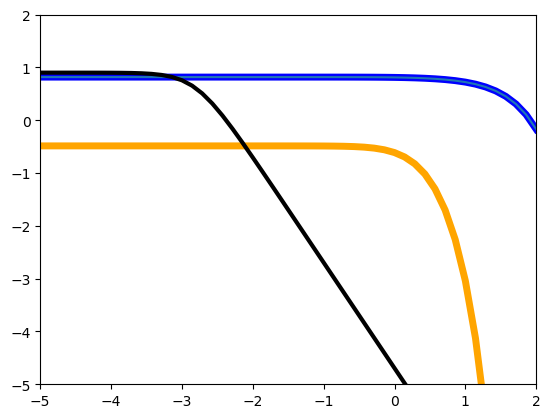

In [253]:
theta_init_alpha_p1 = theta_init.copy()
theta_init_alpha_m1 = theta_init.copy()
theta_init_alpha_p1['log_alpha'] = jnp.array([theta_init['log_alpha'][0]+0.2,
                                        theta_init['log_alpha'][1]])
theta_init_alpha_m1['log_alpha'] = jnp.array([theta_init['log_alpha'][0]-3,
                                        theta_init['log_alpha'][1]])

single_theta_init = theta_init
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='orange', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_alpha_p1
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='red', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_alpha_m1
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='blue', lw=5, label="inferred stochastic kernel")    
    
plt.xlim(-5, 2)
plt.ylim(-5, 2)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")
plt.plot(np.log10(freq), np.log10(true_psd(freq)), label="real stochastic kernel", color='black', lw=3);


In [259]:
theta_init_alpha_m2

{'log_alpha': DeviceArray([  4.60517019, -10.        ], dtype=float64),
 'log_beta': 0.1823215567939546,
 'log_per_amp': 1.791759469228055,
 'log_scale': 1.6094379124341003,
 'log_sigma': 1.4586150226995167}

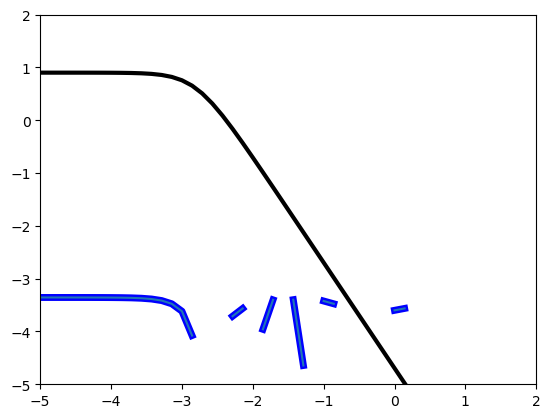

In [268]:
theta_init = {
     "log_alpha": np.log([1000000, 1]),
    "log_beta": np.log(0.2),
    "log_per_amp": np.log(1.0),
    "log_scale": np.log(7.0),
    "log_sigma": np.log(2.3)
}


theta_init_alpha_p2 = theta_init.copy()
theta_init_alpha_m2 = theta_init.copy()
theta_init_alpha_p2['log_alpha'] = jnp.array([theta_init['log_alpha'][0],
                                        theta_init['log_alpha'][1]+0.2])
theta_init_alpha_m2['log_alpha'] = jnp.array([theta_init['log_alpha'][0],
                                        theta_init['log_alpha'][1]-10])


single_theta_init = theta_init
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='orange', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_alpha_p2
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='red', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_alpha_m2
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='blue', lw=5, label="inferred stochastic kernel")    
    
plt.xlim(-5, 2)
plt.ylim(-5, 2)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")
plt.plot(np.log10(freq), np.log10(true_psd(freq)), label="real stochastic kernel", color='black', lw=3);


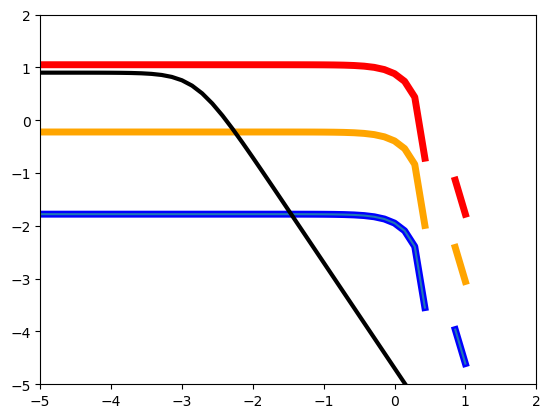

In [214]:
# beta is just the amplitude of the stochastic process 

theta_init_beta_p = {
     "log_alpha": np.log([1, 1.2]),
    "log_beta": np.log(5.2),
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(5.0),
    "log_sigma": np.log(4.3)
}

theta_init_beta_m = {
     "log_alpha": np.log([1, 1.2]),
    "log_beta": np.log(0.2),
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(5.0),
    "log_sigma": np.log(4.3)
}


single_theta_init = theta_init
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='orange', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_beta_p
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='red', lw=5, label="inferred stochastic kernel")

single_theta_init = theta_init_beta_m
soln.params['log_alpha'] = jnp.array([single_theta_init['log_alpha'][0],
                                    single_theta_init['log_alpha'][1]])
soln.params['log_beta'] = jnp.array(single_theta_init['log_beta'])
soln.params['log_per_amp'] = jnp.array(single_theta_init['log_per_amp'])
soln.params['log_scale'] = jnp.array(single_theta_init['log_scale'])
soln.params['log_sigma'] = jnp.array(single_theta_init['log_sigma'])
gp = build_gp(soln.params, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), 
            color='blue', lw=5, label="inferred stochastic kernel")    
    
plt.xlim(-5, 2)
plt.ylim(-5, 2)
plt.plot(np.log10(freq), np.log10(gp.kernel.kernel1(freq[:1], freq)[0]), label="inferred stochastic kernel")
plt.plot(np.log10(freq), np.log10(true_psd(freq)), label="real stochastic kernel", color='black', lw=3);

# Testing

In [ ]:
single_l = res_man[0][:,0]
single_l[single_l<1000]

array([326.91527313, 744.44055315, 615.52125884, 391.65612121,
       219.7293707 , 293.37260375, 256.22835982, 935.41451956,
       790.57228242, 301.05009491, 845.7080803 , 392.82024421,
       297.43162393, 969.96158508])

In [ ]:
magerr


array([0.02684108, 0.02674443, 0.02690733, 0.02708472, 0.0269965 ,
       0.02736585, 0.02592806, 0.02701165, 0.02715181, 0.02923685,
       0.02673891, 0.02613137, 0.02612364, 0.02638745, 0.02727576,
       0.02700218, 0.02709199, 0.02755915, 0.02768308, 0.02742906,
       0.02662599, 0.02718118, 0.02705347, 0.02629844, 0.02699153,
       0.0266121 , 0.02780212, 0.02725079, 0.02610386, 0.02719867,
       0.02668559, 0.02637086, 0.02704693, 0.02617655, 0.02652466,
       0.02688761, 0.02613302, 0.02718366, 0.02722361, 0.02745831,
       0.02565681, 0.02790666, 0.02654242, 0.02627696, 0.02698273,
       0.02585186, 0.02767843, 0.02776901, 0.02653608, 0.02484718,
       0.02537598, 0.02660038, 0.02674671, 0.02724798, 0.0287366 ,
       0.02639929, 0.02676432, 0.0268413 , 0.02657367, 0.02688597,
       0.02698197, 0.02696201, 0.02740124, 0.02639164, 0.02675091,
       0.02623731, 0.0271364 , 0.02621395, 0.02658501, 0.02616385],
      dtype=float32)

In [ ]:
    ens_comp_single = ens_comp.loc[v]
    # select r band
    bool_r = ens_comp_single['band']=='r'
    mjd = ens_comp_single['mjd'][bool_r]
    len_cut = np.floor_divide(len(mjd),10)*10
    mjd = mjd[:len_cut].values
    mag = ens_comp_single['mag'][bool_r].values[:len_cut]
    magerr = ens_comp_single['maggerr'][bool_r].values[:len_cut]

    sort_arr = np.argsort(mjd)
    print(sort_arr)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    print(len(mjd))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
70


In [ ]:
    ens_comp_single = ens_comp.loc[v]
    bool_r = ens_comp_single['band']=='r'
    mjd = ens_comp_single['mjd'][bool_r]

In [ ]:
ens_comp_single['mjd'][ens_comp_single['band']=='r']

ps1_objid
74420671639925418    58369.50289
74420671639925418    58372.50320
74420671639925418    58375.50245
74420671639925418    58387.48131
74420671639925418    58422.36926
                        ...     
74420671639925418    59205.25187
74420671639925418    59233.18598
74420671639925418    59233.18646
74420671639925418    59267.13153
74420671639925418    59269.14782
Name: mjd, Length: 73, dtype: float64

In [ ]:
v = 74420597561988984
ens_comp_single = ens_comp.loc[v]
mjd = ens_comp_single['mjd'].values
len_cut = np.floor_divide(len(mjd),20)*20
mjd = mjd[:len_cut]
mag = ens_comp_single['mag'].values[:len_cut]
magerr = ens_comp_single['maggerr'].values[:len_cut]

sort_arr = np.argsort(mjd)
mjd = mjd[sort_arr]
mag = mag[sort_arr]
magerr = magerr[sort_arr]

# 3. evaluate in situ
#obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

#with suppress_stdout_stderr():
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood, jit=True, tol=1)
soln = solver.run(theta_init, t=mjd, y=mag, yerr=magerr)

In [ ]:
soln = solver.run(theta_init, t=mjd, y=mag, yerr=magerr)

NotImplementedError: The derivatives of eigenvectors are not implemented, only eigenvalues. See https://github.com/google/jax/issues/2748 for discussion.

In [ ]:
list_fun_val = []
for i in range(100):
    alt_theta_init = create_alt_theta_init(theta_init)
    soln = solver.run(alt_theta_init, t=mjd, y=mag, yerr=magerr)
    list_fun_val.append([soln.state.fun_val.item(),
                         np.array(soln.params['log_alpha'])[0],
                         np.array(soln.params['log_alpha'])[1],
                         np.array(soln.params['log_beta'])[0],
                         float(soln.params['log_per_amp']),
                         float(soln.params['log_scale']),
                         float(soln.params['log_sigma'])])
    
array_fun_val = np.array(list_fun_val)

/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_81788/3294895378.py:20: R

In [ ]:
array_fun_val

array([[ 5.41677564e+04,  1.80086970e+00,  2.07993834e+00,
         1.41395579e+00,  1.66460516e+00, -1.79226327e-01,
         1.17092652e+01],
       [            inf,  7.15624146e-01, -5.44563816e-01,
                    nan, -5.06539063e-01, -3.84277702e-01,
         9.99804883e+00],
       [            inf,  1.72698199e-01,  4.81916826e-01,
                    nan,  1.19217628e+01,  1.15370026e+00,
         5.06956184e+00],
       [            inf,  2.37222966e+00,  7.33367368e-01,
                    nan,  6.02787978e+00,  2.23602071e+00,
         1.88269974e+00],
       [ 1.34625390e+04,  2.34554364e-01,  1.83865933e+00,
         9.44296690e-01,  9.16568959e+00,  6.74586596e-01,
         4.82472957e+00],
       [            inf,  8.27536989e-01, -3.48823427e-02,
                    nan,  5.24914059e+00,  5.98535156e-02,
         9.18082282e+00],
       [ 3.59725752e+03, -2.85081083e-01,  1.69693200e+00,
         1.19576497e+00, -3.45028131e+00, -9.09123252e-02,
         2.2626360

In [ ]:
for i in len(soln.params):
    


{'log_alpha': DeviceArray([-0.30175605,  0.01782168], dtype=float64),
 'log_beta': DeviceArray([1.92800385], dtype=float64),
 'log_per_amp': DeviceArray(15.27230975, dtype=float64),
 'log_scale': DeviceArray(0.6992803, dtype=float64),
 'log_sigma': DeviceArray(8.86210455, dtype=float64)}

In [ ]:
np.array(soln.params['log_beta'])[0]

1.9280038457636646

# Getting DRW with single alpha and beta 

In [10]:
import eztao.carma

In [26]:
import eztao
import numpy as np
import matplotlib.pyplot as plt
print(eztao.__version__)

from eztao.carma import DRW_term
from eztao.ts import gpSimRand
from eztao.carma import gp_psd

0.4.0


In [27]:
amp = 0.2
tau = 100
alpha, beta = eztao.carma.CARMATerm.DRW_term(log_amp = np.log(amp), log_tau = np.log(tau)).get_carma_parameter()

In [28]:
# simulate stohastic component
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

In [29]:
np.log(100)

4.605170185988092

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

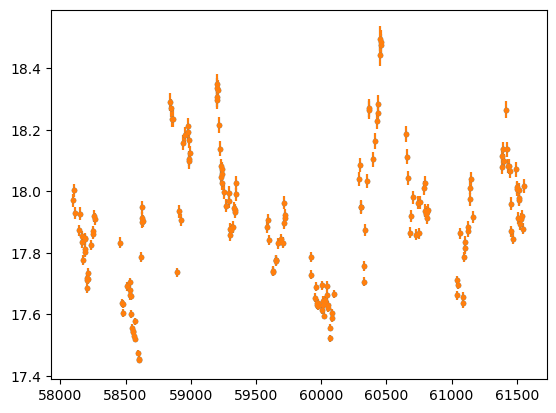

In [31]:
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
mjd = t + 58000

mag = y + 18 
# periodic component added
# mag_per = y + 18 + y_per

magerr = yerr
plt.errorbar(mjd, mag, magerr, fmt='.')
plt.errorbar(mjd, y + 18, magerr, fmt='.')

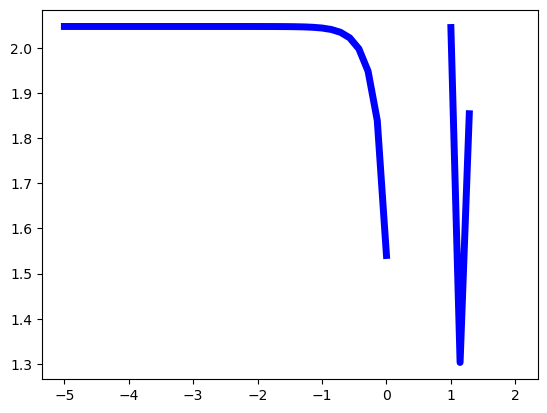

In [41]:
# define grid over which to evaluate
freq = np.logspace(-5, 2)
# true_psd = gp_psd(DRW_kernel)

with suppress_stdout_stderr():
    gp = build_gp(theta_init, mjd, mag, magerr)
    cond_gp = gp.condition(mag, x).gp
    mu, var = cond_gp.loc, cond_gp.variance

gp = build_gp(theta_init, mjd, mag, magerr)
plt.plot(np.log10(freq), np.log10(gp.kernel(freq[:1], freq)[0]), 
            color='blue', lw=5, label="inferred stochastic kernel")    

In [7]:
import pandas
test = pandas.read_csv('/data3/epyc/data3/hipscat/raw/pan_starrs/detection/detectionForExtraction_S24_P92.csv')  
